In [1]:
from adversary.core.noise_generators import AdditiveNoiseGenerator
from adversary.attacks.whitebox.wb_targeted_attack import TargetedWhiteBoxAttack
from adversary.core.preprocessing import PreprocessingFromFunction
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image

from adversary.core.tensor_ops import TensorOps

In [2]:
model = InceptionV3(weights='imagenet')

def preprocess(x, input):
    input = tf.cast(input, dtype=tf.float32)
    if len(input.shape) == 2:
        input = tf.expand_dims(input, axis=-1)
        input = tf.image.grayscale_to_rgb(input)

    elif len(input.shape) == 3 and input.shape[-1] == 1:
        input = tf.image.grayscale_to_rgb(input)

    input_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
    resized_image = tf.image.resize(input_tensor, (299, 299))
    batch_image = tf.expand_dims(resized_image, axis=0)
    return preprocess_input(batch_image)

    
pp = PreprocessingFromFunction.create(preprocess)

In [3]:
image = Image.open('panda.jpg')
image_array = np.array(image)

np.argmax(model.predict(pp.preprocess(image_array)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([388], dtype=int64)

In [4]:
attacker = TargetedWhiteBoxAttack(model, "cce", "adam", preprocessing=pp)

In [ ]:
noise = attacker.attack(image_array, target_class=20, epochs=200)

4.6513538e-05
6.4316424e-05
9.164479e-05
0.00012676437
0.00017049236
0.00022376278
0.0002847961
0.0003555732
0.00043563102
0.0005230882
0.00061801105
0.00071772194
0.00081508385
0.0009166064
0.0010213103
0.0011331517
0.0012587641
0.0013989899
0.0015540988
0.0017300985
0.0019328778
0.0021507284
0.0024032244
0.0026901714
0.0030245455


In [6]:
np.argmax(model.predict(np.zeros(shape=[1, 229, 229, 3], dtype=np.float32)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([111], dtype=int64)

In [7]:
np.argmax(model.predict(attacker.noise_generator.apply_noise(pp.preprocess(image_array), noise)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


array([20], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


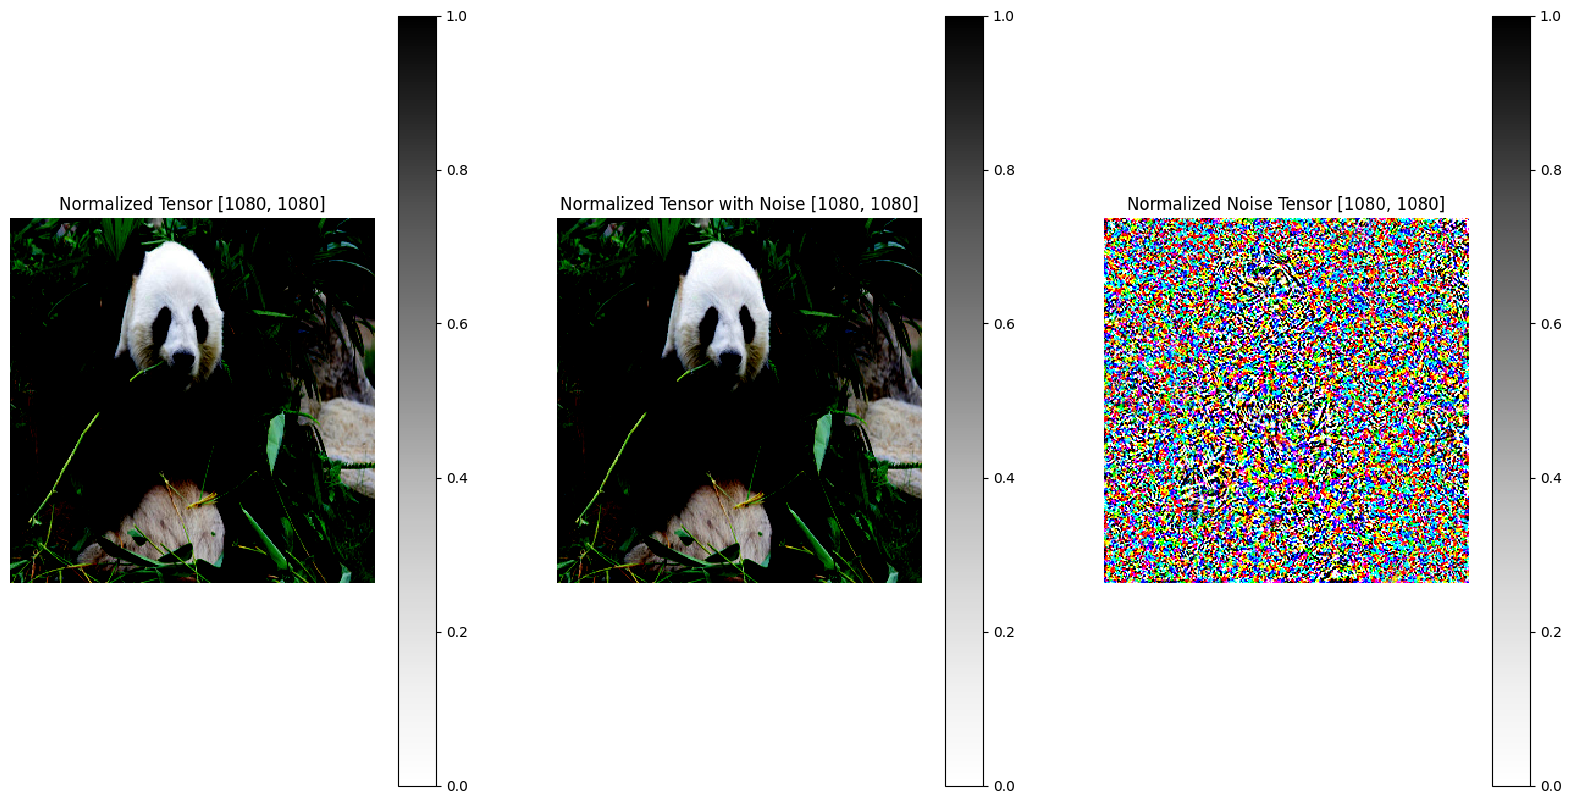

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

im1 = axes[0].imshow(pp.preprocess(image_array)[0])
axes[0].set_title('Normalized Tensor [1080, 1080]')
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(attacker.noise_generator.apply_noise(pp.preprocess(image_array), noise)[0])
axes[1].set_title('Normalized Tensor with Noise [1080, 1080]')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1])


normalized_noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))
im3 = axes[2].imshow(normalized_noise[0])
axes[2].set_title('Normalized Noise Tensor [1080, 1080]')
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2])

plt.show()
